# Find epochs with concurrent neural and watch data

For subjects with paired RC+S and Apple watch streaming, here is some example code to find both neural and watch data using the `availability` expression. The user specifies a resolution of interest (per day, per hour, per 10 minutes, etc.), and the API request will output 0's and 1's for data availability per time bin. Even if there is only 1 second of data available within a bin, the output is 1. Note that the finest resolution available is 5 minute bins.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from runeq import Config, stream

### Functions checking data availability
The functions below at wrapper functions for checking neural and accelerometry data availability.

In [2]:
def check_neural_data_availability(client, params):
    """
    Finds neural data availability within some time frame
    Outputs: dataframe with 0's and 1's for data availability per timestamp
    """

    accessor = client.LFP(expression='availability(lfp)', **params)

    df = pd.DataFrame()
    for page in accessor.iter_json_availability():
        df_page = pd.DataFrame()
        for idx, key in enumerate(page['data'].keys()):
            df_page.insert(idx, key, page['data'][key])
        df_page.insert(0, 'time', page['time'])
        df = df.append(df_page, ignore_index=True)

    return df


def check_accel_data_availability(client, params):
    """
    Finds accel data availability within some time frame
    Outputs: dataframe with 0's and 1's for data availability per timestamp
    """

    accessor = client.Accel(expression='availability(accel)', **params)

    df = pd.DataFrame()
    for page in accessor.iter_json_availability():
        df = pd.DataFrame(page['availability(accel)'])
        df.insert(0, 'time', page['time'])

    return df

### Functions for finding data epochs

`find_epochs` find the start/end points of data epochs based on matches to some specified state, in which time stamps are continuous. For example, if we have a list of data availability (which are 0's and 1's), we can use this function to find the start/end of each continuous segment of 1's. `find_overlapping_epochs` takes multiple data epochs and finds the intersecting time points in which all conditions were met. For example, if epochs with neural data and epochs with accelerometry data were entered, it would return epochs in which both neural + accelerometry data were available. The final function `plot_epochs` plots start/end of each epoch.

In [3]:
def find_epochs(timestamp_series, state_series, state_match):
    """
    Returns start/stop time of data epochs based off state changes
    For example, we want to find all data epochs in which sampling rate == 250
    Each epoch starts when the first sampling rate event == 250
    Each epoch ends when sampling rate changes to different value

    Input:
        time_series - unix time stamps for each state <pd series>
        state_series - values for a particular state <pd series>
        state_match - desired state value <int, float, or string>
    Output:
        epochs - list of unix time stamps for epoch start/stop
    """

    # calculate changes in adjacent values to identify state changes
    match = pd.DataFrame([1 if x == state_match else 0 for x in state_series])
    match['change'] = match.diff()

    # when 'change' is 0, then a current value is same as previous value
    # an epoch begins when the change value is 1
    # an epoch ends when the change value is -1
    start_idx = [((np.isnan(x) and y == 1) or x == 1)
                 for x, y in zip(match['change'], match[0])]
    stop_idx = [x == -1 for x in match['change']]

    # obtain datetime stamps for the start and stop of all epochs
    window_start = timestamp_series[start_idx]
    window_stop = timestamp_series[stop_idx]

    # if the last epoch has no stop, add the last datetime stamp as the stop
    if len(window_start) > len(window_stop):
        window_stop = window_stop.append(
            pd.Series(timestamp_series.iloc[-1]),
            ignore_index=True
        )

    # make array of start/stop times
    epochs = np.array([window_start[:], window_stop[:]]).transpose()

    return epochs


def find_overlapping_epochs(*conditions):
    """
    Return epochs where all conditions are true.

    Input:
        One or more conditions. Each condition is a list of epochs.
        Each epoch is a list/tuple with 2 elements: the start and
        end time of a time interval where the condition was true.

    Output:
        A list of tuples, where each tuple represents the start and
        end time of an epoch where all the conditions are true
    """

    # Compile a set of all the timestamps (the start times AND
    # end times of any of our conditions).
    times = set()

    # Also create a dictionary that summarizes the overall change at
    # each timestamp: the net number of conditions that "turn on" (or
    # "become" true).
    change_at_time = defaultdict(int)

    for condition in conditions:
        for epoch in condition:
            start, end = epoch
            times.add(start)
            times.add(end)
            # When a condition starts, the change at time t is positive
            change_at_time[start] += 1
            # When a condition ends, the change at time t is negative
            change_at_time[end] -= 1

    results = []

    # Now go through the timestamps *in order*, and keep track of
    # the cumulative sum of change_at_time:
    num_on = 0

    num_conditions = len(conditions)

    # When we find a timestamp where all of the conditions are true
    # (i.e. cumulative sum = num_conditions), we'll keep track of the
    # start time:
    current_epoch_start = None

    for time in sorted(times):
        num_on += change_at_time[time]
        if num_on == num_conditions and current_epoch_start is None:
            current_epoch_start = time

        if num_on != num_conditions and current_epoch_start is not None:
            results.append((current_epoch_start, time))
            current_epoch_start = None

    if not results:
        print('No epochs matching all criteria')

    return results


def plot_epochs(condition_names, *conditions):
    """
    Plots data availability for one or more conditions

    Input: List of condition names, list of start/end times for epochs per
    condition
    """

    num_conditions = len(conditions)

    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, condition in enumerate(conditions):
        for epoch in condition:
            ax.plot(
                [datetime.datetime.fromtimestamp(epoch[0]),
                 datetime.datetime.fromtimestamp(epoch[1])],
                [idx, idx],
                linewidth=25
            )

    plt.xticks(rotation=90)
    plt.yticks(np.arange(num_conditions), condition_names)
    plt.tight_layout()
    plt.xlabel('Time')
    plt.ylabel('Filter Criteria')
    plt.title('Data Availability')

Be sure to obtain the credentials for the RC+S in addition to the Apple Watch, and to use the appropriate device_id when checking for neural/accel data availability. 

## 1. Initialize API credentials

In [4]:
# set up client

cfg = Config('/Users/witney/Documents/api_config/adbs05_config.yaml')
client = stream.V1Client(cfg)

## 2. Check data availability

### Example 1

In a single patient, we will check for data availability on a daily basis for the month of March 2020.

In [5]:
# initialize neural availability parameters

neural_params = {
    'device_id': 'c0Cg11Ub',
    'start_time': datetime.datetime(2020, 3, 1).timestamp(),
    'end_time': datetime.datetime(2020, 4, 1).timestamp(),
    'channels': '0,1,2,3',
    'resolution': 60 * 60 * 24,
    'timestamp': 'unix'
}

In [6]:
# initialize accel availability parameters

accel_params = {
    'device_id': '6*yEoMb2',
    'start_time': datetime.datetime(2020, 3, 1).timestamp(),
    'end_time': datetime.datetime(2020, 4, 1).timestamp(),
    'resolution': 60 * 60 * 24,
    'timestamp': 'unix'
}

In [7]:
# check data availability with daily resolution

neural_data_avail_daily = check_neural_data_availability(client, neural_params)
accel_data_avail_daily = check_accel_data_availability(client, accel_params)

In [8]:
# days with both accel + neural

all_avail_daily = neural_data_avail_daily.time[
    (neural_data_avail_daily['channel.0'] == 1)
    & (accel_data_avail_daily[0] == 1)
]

In [9]:
# print days with both channel 0 and accel recordings

pd.to_datetime(all_avail_daily, unit='s')

4    2020-03-05
5    2020-03-06
6    2020-03-07
7    2020-03-08
8    2020-03-09
9    2020-03-10
10   2020-03-11
11   2020-03-12
12   2020-03-13
13   2020-03-14
14   2020-03-15
15   2020-03-16
17   2020-03-18
18   2020-03-19
19   2020-03-20
20   2020-03-21
21   2020-03-22
22   2020-03-23
23   2020-03-24
24   2020-03-25
26   2020-03-27
27   2020-03-28
28   2020-03-29
29   2020-03-30
Name: time, dtype: datetime64[ns]

### Example 2

Next, we will check data availability with a higher resolution (every 10 minutes) in the same time frame.

In [10]:
neural_data_avail_fine_res = pd.DataFrame()
accel_data_avail_fine_res = pd.DataFrame()

# loop through all the days in our time range and check for data per 10 min bin
for start_day in all_avail_daily:
    start_time = start_day
    end_time = start_day + 60*60*24
    neural_params = {
        'device_id': 'c0Cg11Ub',
        'start_time': datetime.datetime(2020, 3, 1).timestamp(),
        'end_time': datetime.datetime(2020, 4, 1).timestamp(),
        'channels': '0,1,2,3',
        'resolution': 60*10,
        'timestamp': 'unix'
    }
    accel_params = {
        'device_id': '6*yEoMb2',
        'start_time': datetime.datetime(2020, 3, 1).timestamp(),
        'end_time': datetime.datetime(2020, 4, 1).timestamp(),
        'resolution': 60*10,
        'timestamp': 'unix'
    }
    neural_day = check_neural_data_availability(client, neural_params)
    neural_data_avail_fine_res = neural_data_avail_fine_res.append(neural_day)
    accel_day = check_accel_data_availability(client, accel_params)
    accel_data_avail_fine_res = accel_data_avail_fine_res.append(accel_day)

In [11]:
# find overlapping epochs from the timestamps

# timestamps with both neural + accel data
neural_and_accel_time = neural_data_avail_fine_res.time[
    (neural_data_avail_fine_res['channel.0'] == 1)
    & (accel_data_avail_fine_res[0] == 1)
]

# set up dataframe for find_epochs
epochs_neural_and_accel = pd.DataFrame()
epochs_neural_and_accel['time'] = neural_data_avail_fine_res.time
epochs_neural_and_accel['state'] = np.zeros(len(epochs_neural_and_accel))
for idx in np.arange(len(neural_and_accel_time)):
    epochs_neural_and_accel.at[neural_and_accel_time.index[idx], 'state'] = 1

# epochs with neural + accel data
epochs_neural_and_accel = find_epochs(
    epochs_neural_and_accel.time,
    epochs_neural_and_accel.state,
    1
)

In [12]:
# find individual epochs

epochs_neural = find_epochs(
    neural_data_avail_fine_res.time,
    neural_data_avail_fine_res['channel.0'],
    1
)
epochs_accel = find_epochs(
    accel_data_avail_fine_res.time,
    accel_data_avail_fine_res[0],
    1
)

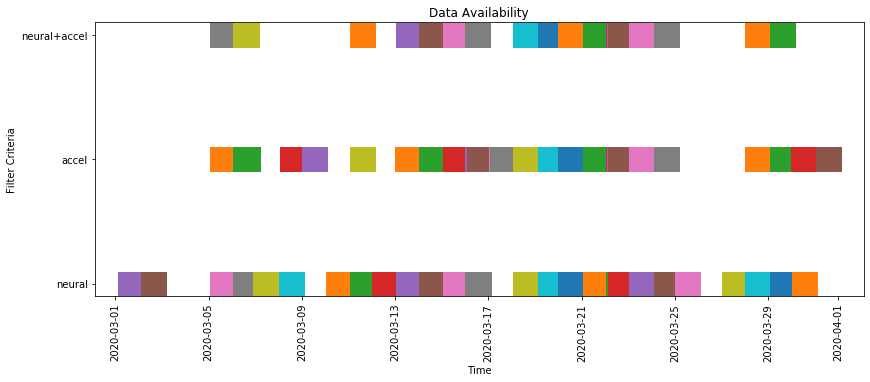

In [13]:
# plot data availability

plot_epochs(
    [
        'neural',
        'accel',
        'neural+accel'
    ],
    epochs_neural,
    epochs_accel,
    epochs_neural_and_accel
)

To obtain the raw neural time series and accelerometry data, we can then loop through the `epochs` variable and use `get_neural_time_series` and `get_accel` from the previous notebooks `01_download_neural_data` and `02_download_watch_data`, respectively.

Other uses of the `availability` expression:
- Find bilateral data (run `check_neural_data_availability` for each hemisphere)
- After filtering for meta data and obtaining a list of epochs of neural data, loop through epochs and check accel availability 

## Summary

We checked for concurrent neural and watch data. After relevant epochs are found, we can further filter by meta data parameters.